# Математическая статистика и А/Б-тесты. 

Мы добавили на лендинг с оформлением дебетовой карты информацию о дополнительных кэшбеках, которые появляются благодаря нашим патнерам. Рассчитываем, что это вырастит конверсию из переходов на лендинг в оформление дебетовой карты. 

В приложенном файле вам доступны логи переходов на сайт и последующего оформления карточки за каждый день. 

In [1]:
# Загрузите необходимые пакеты

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats



In [2]:
# Загрузите таблицу в датафрейм

df = pd.read_csv('https://edu.tbank.ru/files/6725bc69-55d5-46b5-a096-a687c4969fe4', sep=',', encoding='utf-8')

In [3]:
# Посмотрите на поля и проанализируйте таблицу: она содержит поля 
# date — дата захода пользователя на лендинг
# id — идентификатор, присвоенный пользователю
# group — группа теста или контроля
# converted – 1, если пользователь оформил карточку и 0, если не оформил

df.head()

,date,id,group,converted
0,2023-08-01,5030836,control,0
1,2023-08-01,5091425,control,0
2,2023-08-01,5106537,control,0
3,2023-08-01,4556522,control,0
4,2023-08-01,4002917,control,0


In [4]:
# убедитесь,что пользователи уникальные

print('Все пользователи уникальны' if df['id'].nunique() == df['id'].count() else 'Есть дубликаты пользователей')

Все пользователи уникальны


In [5]:
# убедитесь, что пользователей в тесте и контроле приблизительно равное количество

# считаем количество пользователей в каждой группе и их общее количество.
count_control = df[df['group'] == 'control']['id'].count()
count_test = df[df['group'] == 'test']['id'].count()
total = df['id'].count()

# выводим и оцениваем процент людей в каждой группе
print(f'В контрольной группе {count_control / total * 100}% пользователей')
print(f'В тестовой группе {count_test / total * 100}% пользователей')

В контрольной группе 49.93774926670746% пользователей
В тестовой группе 50.06225073329254% пользователей


In [6]:
# убедитесь, что в каждой группе каждый день теста были пользователи, и они как оформляли карту, так и нет

# сделаем сводную таблицу, где будем считать количество уникальных значений converted для каждой группы. 
# Если были дни, когда в какой-то группе только оформляли карту, или только не оформляли, то в столбце будет значение < 2. 
pivot_df = df.pivot_table(index='date', columns='group', values='converted', aggfunc=pd.Series.nunique)

print('Есть дни, где были только 0 или только 1.' if (pivot_df < 2).any().any() else 'Во все дни были как оформленныe, так и неоформленныe карты.')

Во все дни были как оформленныe, так и неоформленныe карты.


In [7]:
# отличаются ли конверсии в тесте и в контроле?

# выделяем отдельно данные с тестовой группой и контрольной группой, считаем конверсии для каждой группы как отношение успешно оформленных карт к общему числу посетителей сайта. 
df_control = df[df['group'] == 'control']
df_test = df[df['group'] == 'test']
conv_control = df_control['converted'].sum() / count_control
conv_test = df_test['converted'].sum() / count_test

In [8]:
# конверсия в контроле: 
print(f'Конверсия в контрольной группе составила {conv_control}')

Конверсия в контрольной группе составила 0.10399323896049018


In [9]:
# конверсия в тесте: 
print(f'Конверсия в тестовой группе составила {conv_test}')

Конверсия в тестовой группе составила 0.11958354409037261


In [10]:
# отношение конверсий: 
diff = conv_test - conv_control
relative_diff = round((conv_test / conv_control - 1) * 100, 2)

print(f'Абсолютная разница конверсий равна {diff}')
print(f'Относильная разница конверсий равна {relative_diff}%')

print(f'Конверсия в тестовой группе на {relative_diff}% выше, чем в контрольной.' if conv_test > conv_control else f'Конверсия в контрольной группе на {relative_diff}% выше, чем в тестовой.')


Абсолютная разница конверсий равна 0.015590305129882437
Относильная разница конверсий равна 14.99%
Конверсия в тестовой группе на 14.99% выше, чем в контрольной.


In [11]:
# значимо ли это отличие? 
# проверьте статистическим тестом

# проведем Z-тест для пропорций, тк у нас бинарные данные (converted или 0, или 1).

from statsmodels.stats.proportion import proportions_ztest

# записываем оформленные карты в одну переменную, общее количество пользователей каждой группы в другую
successes = [df_control['converted'].sum(), 
             df_test['converted'].sum()]
samples = [count_control, count_test]

# проводим тест
z_stat, p_value = proportions_ztest(successes, samples)

print(f'Z-статистика: {z_stat}')
print(f'P-value: {p_value}')

# проверяем для 99% доверительного интервала
alpha = 0.01 
print('Различие статистически значимо. Можно считать с 99% увереностью, что тестовая версия показала себя лучше контрольной.' if p_value < alpha else 'Нет статистически значимого различия между группами.')



Z-статистика: -7.6156153114467555
P-value: 2.624382269741137e-14
Различие статистически значимо. Можно считать с 99% увереностью, что тестовая версия показала себя лучше контрольной.


In [12]:
# достаточно ли длинным был тест, чтобы мы могли посчитать средние конверсии и сравнить значимость их различия? 
# посчитайте количество дней теста, убедитесь, что среди них нет пропусков

# меняем формат столбика с датами на datetime, находим первый и последний день теста, считаем длительность теста. 
df['date'] = pd.to_datetime(df['date']).dt.date
min_date = df['date'].min()
max_date = df['date'].max()
days_in_test = (max_date - min_date).days + 1

# генерируем все даты в интервале от первого дня теста до последнего, ищем пропущенные даты
all_dates = pd.date_range(start=min_date, end=max_date, freq='D').date
missing_dates = set(all_dates) - set(df['date'])

print(f'Всего было {days_in_test} дней теста')
print(f'Пропущено {len(missing_dates)} дней' if missing_dates else 'Пропущенных дней нет')

Всего было 93 дней теста
Пропущенных дней нет


In [13]:
# посчитайте количество открытых карт и средние конверсии по дням в тесте и в контроле:

# группируем данные для каждой группе по датам, добавляем новые столбики с общим числом оформленных карт и общим числом посетителей.
test_conv_by_date = df_test.groupby('date').agg(
    total_conversions=('converted', 'sum'),
    total_visits=('converted', 'count')
    ).reset_index()

control_conv_by_date =  df_control.groupby('date').agg(
    total_conversions=('converted', 'sum'),
    total_visits=('converted', 'count')
    ).reset_index()

# добавляем столбик с конверсией
control_conv_by_date['conversion_rate'] = control_conv_by_date['total_conversions'] / control_conv_by_date['total_visits']
test_conv_by_date['conversion_rate'] = test_conv_by_date['total_conversions'] / test_conv_by_date['total_visits']
control_conv_by_date

,date,total_conversions,total_visits,conversion_rate
0,2023-08-01,45,512,0.087891
1,2023-08-02,63,512,0.123047
2,2023-08-03,60,547,0.109689
3,2023-08-04,56,486,0.115226
4,2023-08-05,54,513,0.105263
...,...,...,...,...
88,2023-10-28,55,536,0.102612
89,2023-10-29,46,513,0.089669
90,2023-10-30,60,519,0.115607
91,2023-10-31,54,507,0.106509


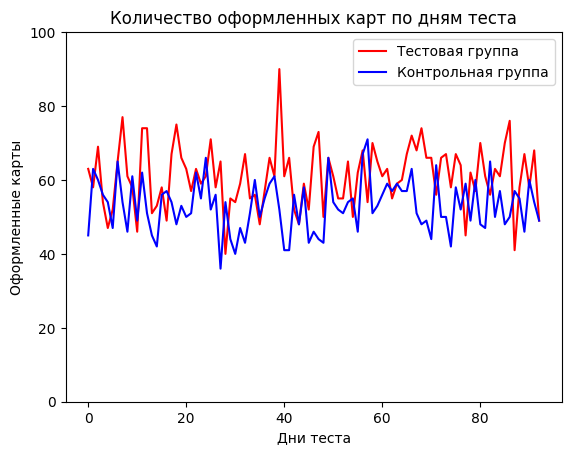

In [14]:
# построим график, отражающий количество оформленных карт по дням

sns.lineplot(data = test_conv_by_date['total_conversions'], color="red", label='Тестовая группа')
sns.lineplot(data = control_conv_by_date['total_conversions'], color="blue", label='Контрольная группа')

plt.title('Количество оформленных карт по дням теста')
plt.xlabel('Дни теста')
plt.ylabel('Оформленные карты')
plt.legend()
plt.ylim(0, 100)

plt.show()

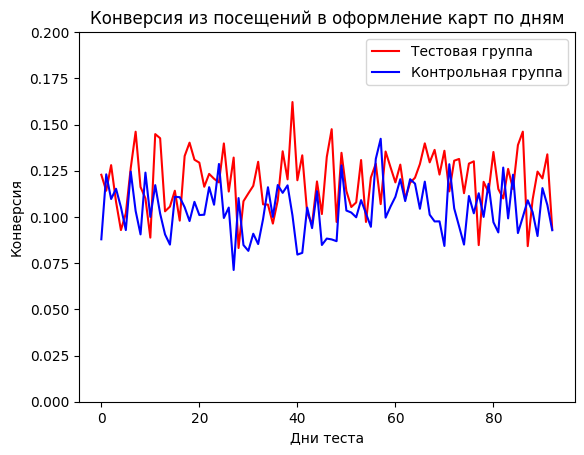

In [15]:
# построим график, отражающий конверсию из посещений в оформленние карт по дням

sns.lineplot(data=test_conv_by_date['conversion_rate'], color='red', label='Тестовая группа')
sns.lineplot(data=control_conv_by_date['conversion_rate'], color='blue', label='Контрольная группа')

plt.title('Конверсия из посещений в оформление карт по дням')
plt.xlabel('Дни теста')
plt.ylabel('Конверсия')
plt.legend()
plt.ylim(0, 0.2)

plt.show()

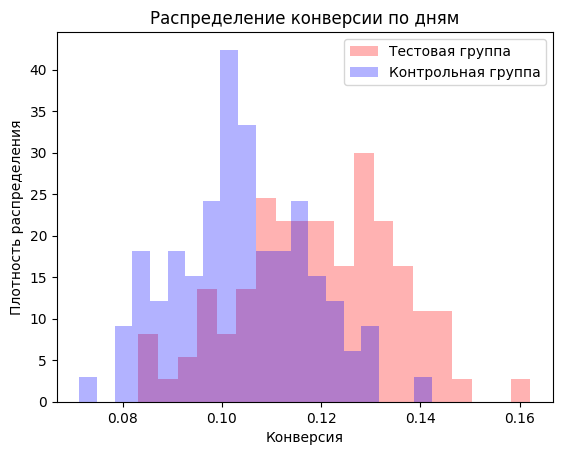

In [16]:
# построим распределения средних значений по дням в тесте и в контроле

plt.hist(test_conv_by_date['conversion_rate'], bins=20, density=True, color='r', alpha=0.3, label='Тестовая группа')
plt.hist(control_conv_by_date['conversion_rate'], bins=20, density=True, color='b', alpha=0.3, label='Контрольная группа')

plt.title('Распределение конверсии по дням')
plt.xlabel('Конверсия')
plt.ylabel('Плотность распределения')
plt.legend()

plt.show()

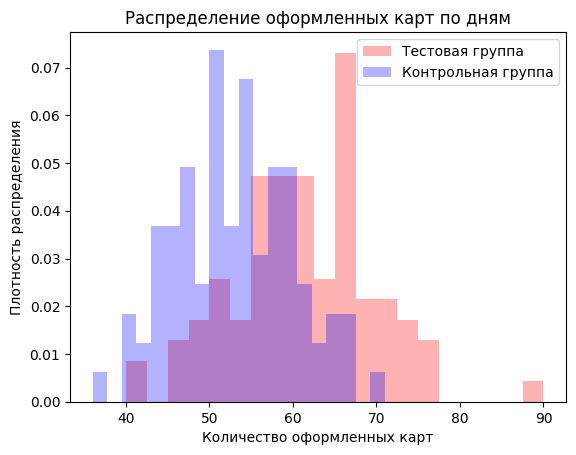

In [17]:
plt.hist(test_conv_by_date['total_conversions'], bins=20, density=True, color='r', alpha=0.3, label='Тестовая группа')
plt.hist(control_conv_by_date['total_conversions'], bins=20, density=True, color='b', alpha=0.3, label='Контрольная группа')

plt.title('Распределение оформленных карт по дням')
plt.xlabel('Количество оформленных карт')
plt.ylabel('Плотность распределения')
plt.legend()

plt.show()

In [18]:
# теперь используем знание о том, что средние конверсии распределены нормально, проведите тест

# проведем t-тест
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(control_conv_by_date['conversion_rate'], test_conv_by_date['conversion_rate'])

print(f't-статистика: {t_stat}')
print(f'P-значение: {p_value}')

# проверяем для 99% доверительного интервала
alpha = 0.01
print('Конверсии в контрольной и тестовой группах статистически различны, можно отвергнуть нулевую гипотезу' if p_value < alpha else 'Нет статистически значимого различия.')



t-статистика: -7.209029622736518
P-значение: 1.4124701519287306e-11
Конверсии в контрольной и тестовой группах статистически различны, можно отвергнуть нулевую гипотезу


In [19]:
# используйте тот же статистический тест, чтобы оценить, отличаются ли  и проинтерпретируйте результаты
# как меняется ваш результат в зависимости от принятого вами уровня значимости?

t_stat, p_value = ttest_ind(control_conv_by_date['total_conversions'], test_conv_by_date['total_conversions'])

print(f't-статистика: {t_stat}')
print(f'P-значение: {p_value}')

# проверяем для 99% доверительного интервала
alpha = 0.01
print('Конверсии в контрольной и тестовой группах статистически различны, можно отвергнуть нулевую гипотезу' if p_value < alpha else 'Нет статистически значимого различия.')

t-статистика: -7.048113433738303
P-значение: 3.529180601649641e-11
Конверсии в контрольной и тестовой группах статистически различны, можно отвергнуть нулевую гипотезу


# Результаты теста:
- Конверсия в тестовой группе оказалась на 15% выше, чем в контрольной;
- Статистические z-тест и t-тесты подтвердили значимость данного различия на 99% уровне значимости.

## Итог: 
Добавление информации о дополнительных кэшбеках на лендинг с оформлением дебетовой карты **значительно увеличило** количество оформленных карт и **повысило** общую конверсию. Тесты и графики подтверждают, что изменения **положительно сказались** на эффективности страницы.
